<a href="https://colab.research.google.com/github/camilo47/PythonProyectoFinal/blob/master/test_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"11f96V-uOqzfg8WUKlEp0-B_VpCvLycBB"})   # replace the id with id of file you want to access
downloaded.GetContentFile('datanew.csv')

            dia
fecha          
2018-01-01    3
2018-02-01    2
2018-03-01    1
2018-04-01    2
2018-05-01   11
2018-06-01    5
2018-07-01    4
2018-08-01   15
2018-09-01   13
2018-10-01   11
2018-11-01    9
2018-12-01    7


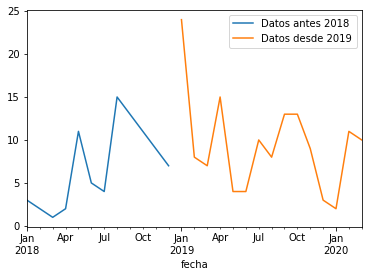

Epoch 1/20
8/8 [==============================] - 0s 32ms/step - loss: 0.4503
Epoch 2/20
8/8 [==============================] - 0s 741us/step - loss: 0.3923
Epoch 3/20
8/8 [==============================] - 0s 777us/step - loss: 0.3538
Epoch 4/20
8/8 [==============================] - 0s 572us/step - loss: 0.3230
Epoch 5/20
8/8 [==============================] - 0s 774us/step - loss: 0.2965
Epoch 6/20
8/8 [==============================] - 0s 716us/step - loss: 0.2730
Epoch 7/20
8/8 [==============================] - 0s 640us/step - loss: 0.2518
Epoch 8/20
8/8 [==============================] - 0s 620us/step - loss: 0.2324
Epoch 9/20
8/8 [==============================] - 0s 605us/step - loss: 0.2145
Epoch 10/20
8/8 [==============================] - 0s 448us/step - loss: 0.1982
Epoch 11/20
8/8 [==============================] - 0s 729us/step - loss: 0.1831
Epoch 12/20
8/8 [==============================] - 0s 649us/step - loss: 0.1693
Epoch 13/20
8/8 [==============================] -

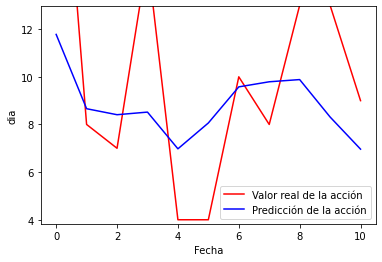

[[11.779251 ]
 [ 8.660781 ]
 [ 8.409021 ]
 [ 8.518585 ]
 [ 6.977583 ]
 [ 8.062443 ]
 [ 9.577806 ]
 [ 9.791283 ]
 [ 9.883876 ]
 [ 8.312899 ]
 [ 6.9638324]]


In [46]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Fecha')
    plt.ylabel('dia')
    plt.legend()
    plt.show()

#
# Lectura de los datos
#
dataset = pd.read_csv('datanew.csv', index_col='fecha', parse_dates=['fecha'])
dataset.head()

#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#

set_entrenamiento = dataset[:'2018'].iloc[:,0:1]

set_validacion = dataset['2019':].iloc[:,0:1]

print(set_entrenamiento)


set_entrenamiento['dia'].plot(legend=True)
set_validacion['dia'].plot(legend=True)
plt.legend(['Datos antes 2018 ', 'Datos desde 2019'])
plt.show()



# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 4
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)


#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []

for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
    print()
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

print(prediccion)

